In [1]:
import pandas as pd
import nilmtk
import matplotlib.pyplot as plt
import random
import sys
from matplotlib import rcParams
import matplotlib.pyplot as plt
import numpy as np
import h5py
from nilmtk import DataSet
from nilmtk.utils import print_dict
from nilmtk.datastore import HDFDataStore
from matplotlib import rcParams
from nilmtk.utils import find_nearest
from nilmtk.feature_detectors import cluster
from nilmtk.legacy.disaggregate import Disaggregator
from nilmtk.datastore import HDFDataStore
import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model

In [2]:
redd_data = DataSet('E:\\github\\Nilm\\redd_low.h5')

In [3]:
# train_norm = redd_data.buildings[1].elec
# train_mains_norm = train_norm.submeters().power_series_all_data()

In [4]:
# max = train_mains_norm.max()

In [5]:
redd_data = DataSet('E:\\github\\Nilm\\redd_low.h5')
redd_data.set_window(end="30-4-2011") 
train_elec = redd_data.buildings[1].elec
# train_mains = train_elec.mains().all_meters()[0] 
# train_meter = train_elec.submeters()['fridge'] 

In [6]:
train_mains = train_elec.submeters()
train_meter = train_elec.submeters()['fridge']

In [7]:
# train_mains = train_mains.fillna(0)
# train_meter = train_meter.fillna(0)

In [8]:
from RNN import RNNDisaggregator
disaggregator = RNNDisaggregator()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 16)             80        
_________________________________________________________________
bidirectional (Bidirectional (None, 1, 256)            148480    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1050624   
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,264,977
Trainable params: 1,264,977
Non-trainable params: 0
_________________________________________________________________


In [9]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.set_visible_devices(physical_devices[0], 'GPU')

In [10]:
history = disaggregator.train(train_mains, train_meter, epochs=2, sample_period=3)
disaggregator.export_model("model-test_01.h5")

Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')      dataset='REDD'), ElecMeterID(instance=4, building=1, dataset='REDD')))     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')      dataset='REDD'), ElecMeterID(instance=20, building=1, dataset='REDD')))     
Done loading data all meters for this chunk.

Done loading data all meters for this chunk.
get max
Epoch 1/2
4459/4459 [==============================] - 78s 15ms/step - loss: 1.3697e-04 - val_loss: 1.2662e-04
Epoch 2/2
4459/4459 [==============================] - 77s 17ms/step - loss: 9.7338e-05 - val_loss: 1.1921e-04


In [11]:
test = DataSet('E:\\github\\Nilm\\redd_low.h5')
test.set_window(start="30-4-2011")
test_elec = test.buildings[1].elec
test_mains = test_elec.submeters()

In [12]:
disag_filename = 'test_04.h5' # The filename of the resulting datastore
from nilmtk.datastore import HDFDataStore
output = HDFDataStore(disag_filename, 'w')

In [13]:
disaggregator.disaggregate( test_mains,output, train_meter, sample_period=3)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "e:\anaconda\conda\envs\Nilm_01\lib\site-packages\ipython-8.11.0-py3.8.egg\IPython\core\interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\12933\AppData\Local\Temp\ipykernel_74412\1564575889.py", line 1, in <module>
    disaggregator.disaggregate( test_mains,output, train_meter, sample_period=3)
  File "e:\github\NILM\RNN\Fridge\RNN.py", line 124, in disaggregate
    for chunk in mains.power_series(**load_kwargs):
  File "e:\github\nilm\nilmtk\nilmtk\electric.py", line 626, in load_series
    for chunk in generator:
  File "e:\github\nilm\nilmtk\nilmtk\metergroup.py", line 709, in load
    sections = [section for section in sections if section]
TypeError: 'NoneType' object is not iterable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "e:\anaconda\conda\envs\Nilm_01\lib\site-packages\ipython-8.11.0-py3.8.egg\IPython\

In [4]:
result = DataSet('E:\\github\\Nilm\\RNN\\Fridge\\test_01.h5')
res_elec = result.buildings[1].elec

predicted = res_elec['fridge']
ground_truth = test_elec['fridge']

good_sections_pre = predicted.good_sections()
good_sections_true = ground_truth.good_sections()

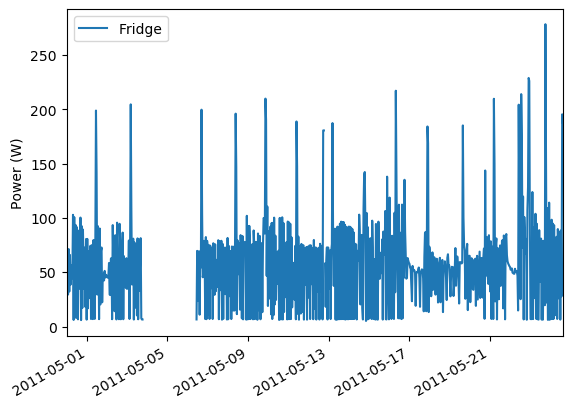

In [5]:
import matplotlib.pyplot as plt
# predicted.plot()
ground_truth.plot()
plt.show()

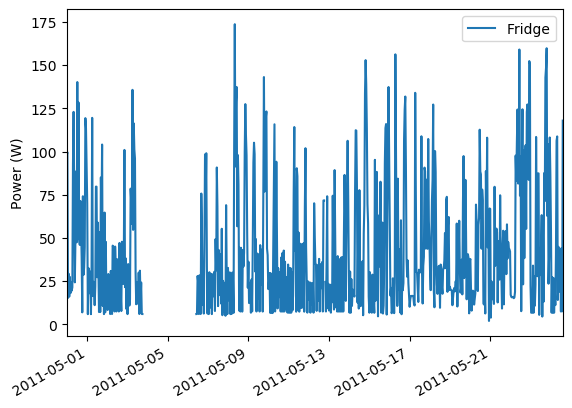

In [6]:
import matplotlib.pyplot as plt
predicted.plot()
# ground_truth.plot()
plt.show()

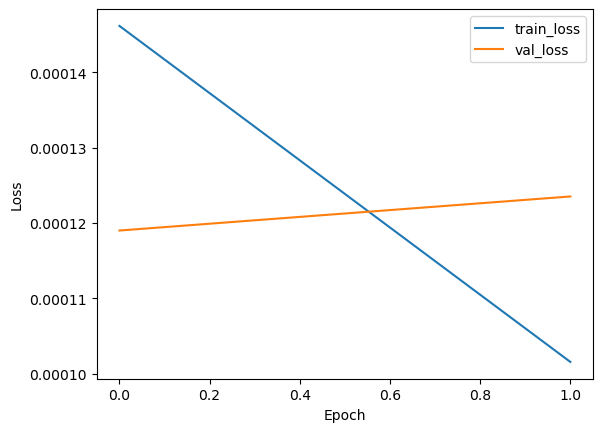

In [8]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['train_loss', 'val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [8]:
from nilmtk.electric import align_two_meters
import numpy as np

def tp_tn_fp_fn(states_pred, states_ground):
    tp = np.sum(np.logical_and(states_pred == 1, states_ground == 1))
    fp = np.sum(np.logical_and(states_pred == 1, states_ground == 0))
    fn = np.sum(np.logical_and(states_pred == 0, states_ground == 1))
    tn = np.sum(np.logical_and(states_pred == 0, states_ground == 0))
    return tp, tn, fp, fn

def recall_precision_accuracy_f1(pred, ground):
    aligned_meters = align_two_meters(pred, ground)
    threshold = ground.on_power_threshold()
    chunk_results = []
    sum_samples = 0.0
    for chunk in aligned_meters:
        sum_samples += len(chunk)
        pr = np.array([0 if (p)<threshold else 1 for p in chunk.iloc[:,0]])
        gr = np.array([0 if p<threshold else 1 for p in chunk.iloc[:,1]])

        tp, tn, fp, fn = tp_tn_fp_fn(pr,gr)
        p = sum(pr)
        n = len(pr) - p

        chunk_results.append([tp,tn,fp,fn,p,n])

    if sum_samples == 0:
        return None
    else:
        [tp,tn,fp,fn,p,n] = np.sum(chunk_results, axis=0)

        res_recall = recall(tp,fn)
        res_precision = precision(tp,fp)
        res_f1 = f1(res_precision,res_recall)
        res_accuracy = accuracy(tp,tn,p,n)

        return (res_recall,res_precision,res_accuracy,res_f1)

def relative_error_total_energy(pred, ground):
    aligned_meters = align_two_meters(pred, ground)
    chunk_results = []
    sum_samples = 0.0
    for chunk in aligned_meters:
        chunk.fillna(0, inplace=True)
        sum_samples += len(chunk)
        E_pred = sum(chunk.iloc[:,0])
        E_ground = sum(chunk.iloc[:,1])

        chunk_results.append([
                            E_pred,
                            E_ground
                            ])
    if sum_samples == 0:
        return None
    else:
        [E_pred, E_ground] = np.sum(chunk_results,axis=0)
        return abs(E_pred - E_ground) / float(max(E_pred,E_ground))

def mean_absolute_error(pred, ground):
    aligned_meters = align_two_meters(pred, ground)
    total_sum = 0.0
    sum_samples = 0.0
    for chunk in aligned_meters:
        chunk.fillna(0, inplace=True)
        sum_samples += len(chunk)
        total_sum += sum(abs((chunk.iloc[:,0]) - chunk.iloc[:,1]))
    if sum_samples == 0:
        return None
    else:
        return total_sum / sum_samples


def recall(tp,fn):
    return tp/float(tp+fn)

def precision(tp,fp):
    return tp/float(tp+fp)

def f1(prec,rec):
    return 2 * (prec*rec) / float(prec+rec)

def accuracy(tp, tn, p, n):
    return (tp + tn) / float(p + n)

In [9]:
relative_error_total_energy(predicted,ground_truth)

0.045826188672607

In [10]:

rpaf = recall_precision_accuracy_f1(predicted, ground_truth)
print("============ Recall: {}".format(rpaf[0]))
print("============ Precision: {}".format(rpaf[1]))
print("============ Accuracy: {}".format(rpaf[2]))
print("============ F1 Score: {}".format(rpaf[3]))

print("============ Relative error in total energy: {}".format(relative_error_total_energy(predicted, ground_truth)))
print("============ Mean absolute error(in Watts): {}".format(mean_absolute_error(predicted, ground_truth)))

============ Recall: 0.6737046319222175
============ Precision: 0.7501449908802837
============ Accuracy: 0.7667631679489987
============ F1 Score: 0.709872934438943
============ Relative error in total energy: 0.045826188672607
============ Mean absolute error(in Watts): 38.89097265163388
